# HW 4 - Supervised Learning at Scale.
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the first three homeworks you became familiar with the Map-Reduce programming paradigm as manifested in the Hadoop Streaming and Spark frameworks. We explored how different data structures and design patterns can help us manage the computational complexity of an algorithm. As part of this process you implemented both a supervised learning alogorithm (Naive Bayes) and an unsupervised learning algorithm (synonym detection via cosine similarity). In both of these tasks parallelization helped us manage calculations involving a large number of features. However a large feature space isn't the only situation that might prompt us to want to parallelize a machine learning algorithm. In the final two assignments we'll look at cases where the iterative nature of an algorithm is the main driver of its computational complexity (and the reason we might want to parallelize it).

In this week's assignment we'll perform 3 kinds of linear regression: OLS, Ridge and Lasso. As in previous assignments you will implement the core calculations using Spark RDDs... though we've provided more of a code base than before since the focus of the latter half of the course is more on general machine learning concepts. By the end of this homework you should be able to:  
* ... __define__ the loss functions for OLS, Ridge and Lasso regression.
* ... __calculate__ the gradient for each of these loss functions.
* ... __identify__ which parts of the gradient descent algorithm can be parallelized.
* ... __implement__ parallelized gradient descent with cross-validation and regularization.
* ... __compare/contrast__ how L1 and L2 regularization impact model parameters & performance.

Additional Reference: [Spark 2.2 Documentation - RDD programming guide](https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html)

__Please refer to the `README` for homework submission instructions and additional resources.__ 

### Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw4_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Opimization Theory 

As you know from w207, Gradient Descent is an iterative process that seeks to find the optimal parameters for a model given a particular training data set. It does this by using the vector of partial derivatives of a loss function to strategically update parameters in a way that will reduce the loss. In live session 6 you discussed some of the theory behnid why gradient descent works and looked at a small example of gradient descent in the context of linear regression.

### Q1 Tasks:

* __a) short response:__ What are the first and second order conditions for convexity and why do we care about them when performing Gradient Descent?

* __b) short response:__ Explain the relationship between problem domain space and model parameter space in the context of Gradient Descent. In practice, why can't we find the optimal model by simply looking at the error surface in model parameter space?

* __c) short response:__ In the context of Gradient Descent, what is the 'learning rate' and what are the tradeoffs associated with setting this hyperparameter?

* __d) BONUS:__ In the context of OLS, what do we mean by a 'closed form solution' and why is it not scalable?

### Q1 Student Answers:
> __a)__ First order condition of convexity: the maximum or minimum of an unconstrained function must occur at a point where the $\nabla{f(x)}$ must be zero. Second order condition of convexity: if $f''(x=x^*) < 0$, then maximum; if $f''(x=x^*) > 0$, then minimum. We care because they are the heart of many machine learning algorithms, and also that the first and order conditions of convexity guarrantees us to find the global minima or maxima when performing Gradient Descent. 

> __b)__ From the __problem domain space__, we think about loss as a measure of how far off the data are from our model. Therefore, we contruct a model function of our data ($X_i$) to predict output variable ($y$), $y = f(x_1, x_2, ..., x_n; \theta)$ where $\theta$ are our parameters. From __model parameter space__, we think about loss as a measure of how far off the current model is from the optimal model. Therefore, from the model function we contruct our objective function which is a function of our parameters $\theta$. Example objective functions such as ordinary least squares, maximum likelihood, etc. Our goal is to find the global minimum or maximum of our objective function. In the context of Gradient Descent, we start somewhere random in the Model Parameter Space and then move down the error surface by a learning rate ($x^{i+1} = x^{i} - \alpha^{i}f'(x^{i})$) to find a minimum point with the optimal parameters for our training data by iterating until x does not change. We cannot find the optimal model by simply looking at the error surface, because we do not have access to the error surface until we've computed the loss for every possible comnination of parameters. Doing so is computationally challenging. 

> __c)__ The learning rate is the rate at which we move along the gradient function. The lower the value, the slower we travel along the slope. If we set the rate too small, the convergence rate is slow and thus we would need more iterations to reach to minima; if we set the rate too large, the convergence rate could be so fast that we might potentially miss the minima. 

> __d)__ In OLS, the closed form solution is \begin{equation}
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}^{'T}_i - y_i\right] \cdot \mathbf{x}^{'T}_i
\end{equation}
where we take the derivative of our objective function ($f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}^{'T}_i - y_i\right]^2$) with respect to the parameters $\boldsymbol{\theta}$, set it to zero, and then solve for $\boldsymbol{\theta}$. But it turns out that this closed form solution can be computationally challenging in higher dimensions. It is especially difficult to invert large matrices.

# About the Data

For the main task in this portion of the homework you will use data about red and white Portuguese wines. [This data](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) was made available to the UC Irvine public repository of Machine Learning datasets by researchers at the University of Minho in association with [this paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub):
> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

The dataset includes 12 fields:
>`fixed acidity`  
`volatile acidity`  
`citric acid`  
`residual sugar`  
`chlorides`  
`free sulfur dioxide`  
`total sulfur dioxide`  
`density`  
`pH`  
`sulphates`  
`alcohol`  
`quality`   -- (_a score between 0 and 10_)

__`IMPORTANT NOTE:`__ The outcome variable in our data is a human assigned score ranging from 0 to 10. Since the scores are integers this is actually an ordinal and not numerical outcome varaible. However for the purposes of this assignment we'll treat it as a numerical quantity.

The data are in two files: one containing red wines and another containing white wines.  Use the following cells to download the data, add a field for red/white, and split it into a test and train set.

In [5]:
# make a data folder & download red & white wine files
!mkdir data
!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

mkdir: cannot create directory `data': File exists


In [6]:
# extract header fields - RUN THIS CELL AS IS
header = !head -n 1 data/reds.csv
header = header[0]
FIELDS = ['color'] + re.sub('"', '', header).split(';')

In [7]:
# load the raw data into an RDD - RUN THIS CELL AS IS
redsRDD = sc.textFile('data/reds.csv')\
            .filter(lambda x: x != header)\
            .map(lambda x: '1;' + x) # set first field 1 to indicate red wine
whitesRDD = sc.textFile('data/whites.csv')\
              .filter(lambda x: x != header)\
              .map(lambda x: '0;' + x) # set first field 0 to indicate white wine

In [8]:
# Generate 80/20 (pseudo)random train/test split - RUN THIS CELL AS IS
trainRDD, heldOutRDD = redsRDD.union(whitesRDD).randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 1316 records for evaluation and assigned 5181 for training.


In [9]:
# helper function - RUN THIS CELL AS IS
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split(';'), dtype = 'float')
    features,quality = fields[:-1], fields[-1]
    return(features, quality)

In [10]:
# cache the training set - RUN THIS CELL AS IS 
trainRDDCached = trainRDD.map(parse).cache()

# Question 2: EDA

A statistician's approach to Linear Regression typically involves a series of EDA steps to examine each feature in the data and then a series of steps to test assumptions about their potential contribution to a multi-feature linear model. In particular, we'd want to look for a set of features that exhibit a likely linear relationship with the outcome variable and that are _not_ highy correlated with each other. In the context of machine learning, these considerations remain important techniques for improving model generalizability despite the common practice to use model evaluation techniques (and large data sets) to get the final word on feature selection. 

In this question we'll briefly look at the features in our data set. To mimic an 'at scale' analysis we'll start by sampling from our Spark RDD training set so that we have a manageable amount of data to work with in our visuals.

### Q2 Tasks:
* __a) short response:__ Run the provided code to sample 1000 points and visualize histograms of each feature. Comment on the distributions you observe (eg. _Which features appear normaly distributed, which don't? Which features vary most/least?_) How is the varaible `color` different than the other features & what does that mean about how we interpret its regression coefficient?

* __b) short response:__ Run the provided code to create boxplots of each feature. Which, if any, appear to have a positive linear relationship with `quality`? Which if any appear to have a negative linear relationship with `quality`?


* __c) short response:__ Run the provided code to plot the correlations matrix. Which pairs of features are most _strongly_ (postively or negatively) associated with each other? What implications would that have for our feature selection?

### Q2 Student Answers:
> __a)__ Obervations on the histograms are summarized below: 
   - These features are close to normally distributed: citric acid, density, fixed acidity, pH. 
   - The other features are not normally distributed:
       - **alcohol** has heavy tail at the range of 9 - 10, and a spike at around 9.5; 
       - **total sulfur dioxide** also has heavy tail at range of 0 - 100. 
   - The **color** variable has only two values: 0 and 1, where 1 corresponds to red, and 0 for white wine. When we interpret its regression coefficient, if the wine is "white", the coefficient associated to `color` won't have any effect on the response variable; but if the wine is "red", then the `color` variable is interpreted as 1, so the response variable will be affected by the asociated coefficient. 

> __b)__ (1) Positive linear relationship: citric acid, free sulfur dioxide, and total sulfur dioxide. (2) Negative linear relationship: fixed acidity, volatile acidity, and pH. Their trends are slightly negative, not very strong. (3) Unclear trend: residual sugar, sulphates, chlorides, alcohol, and density. Their boxplots do not present clear or consistent trends. 

> __c)__ The following pairs of features are most strongly (postively or negatively) associated:
- free sulfur dioxide and total sulfur dioxide: positively
- volatile acidity and color: positively
- total sulfur dioxide and color: negatively
- density and alcohol: negatively

In [11]:
# part a - take a 1000 point sample for EDA (RUN THIS CELL AS IS)
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

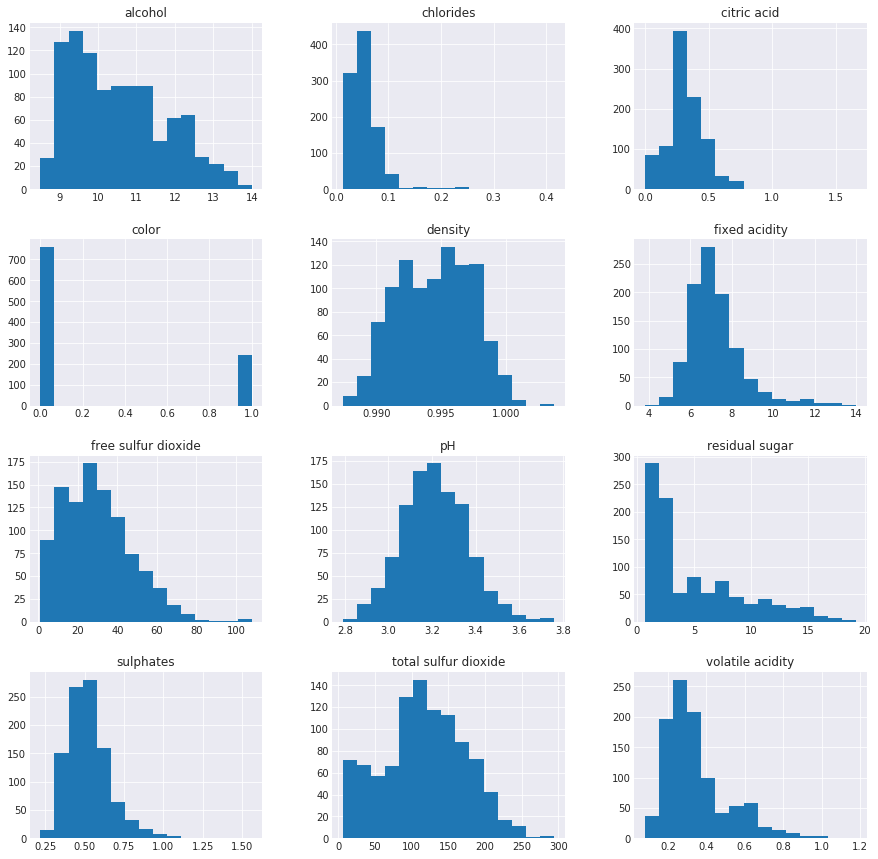

In [12]:
# part a - take a look at histograms for each feature (RUN THIS CELL AS IS)
sample_df[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

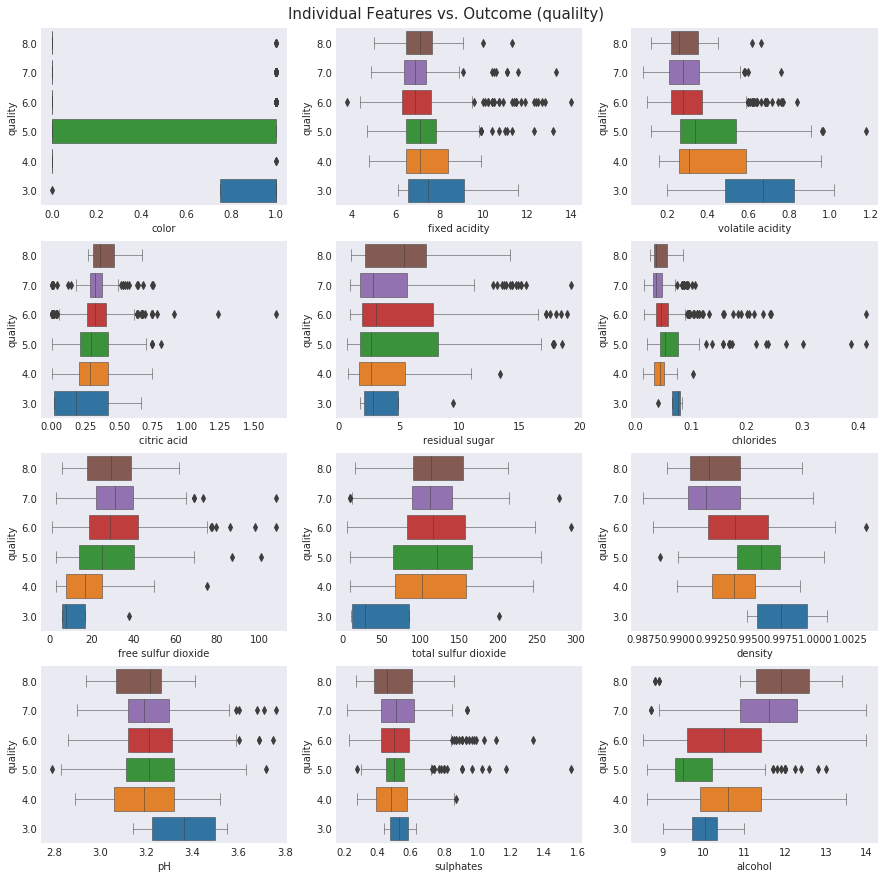

In [13]:
# part b -  plot boxplots of each feature vs. the outcome (RUN THIS CELL AS IS)
fig, ax_grid = plt.subplots(4, 3, figsize=(15,15))
y = sample_df['quality']
for idx, feature in enumerate(FIELDS[:-1]):
    x = sample_df[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
plt.show()

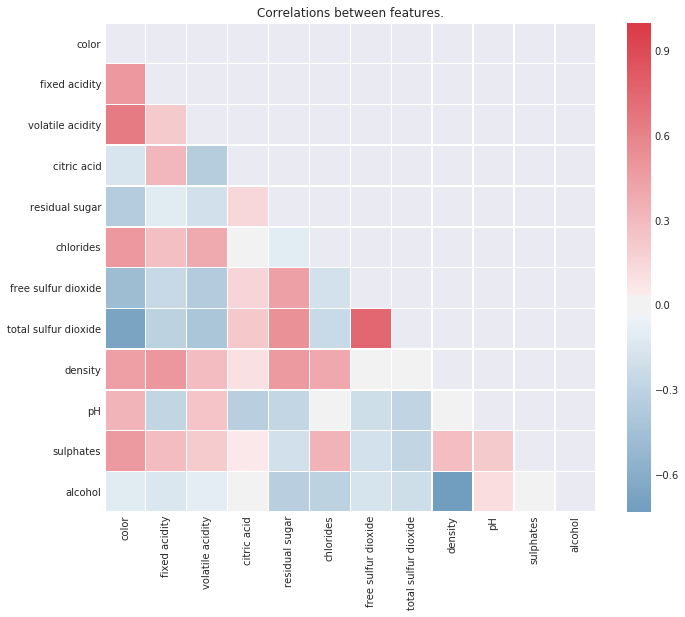

In [14]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample_df[FIELDS[:-1]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

# Question 3: OLS Loss

For a parametric model, the key factor that will impact how easy it is to optimize is your choice of how to define the loss function. In Ordinary Least Squares (OLS) Regression our loss function is just about as convenient as you will get: not only is it convex, its also very easy to interpret. 

When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb. It is useful as a simple baseline to compare with other (real) regressors. Examples of regression baselines include:
* "mean": always predicts the mean of the training set
* "median": always predicts the median of the training set
* "quantile": always predicts a specified quantile of the training set,provided with the quantile parameter.
* "constant": always predicts a constant value that is provided by the user.

In this question you'll "choose" a baseline model and then write a function to compute the loss of a linear model in Spark. You'll reuse this function in Q4 when you implement gradient descent.

#### Baseline example illustrated:

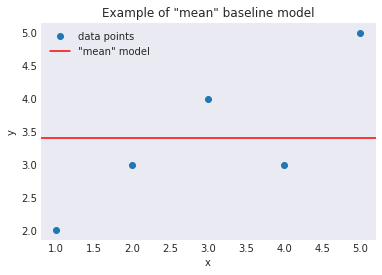

In [15]:
# points from our mini example from the demo 6 notebook  (RUN THIS CELL AS IS)
points = np.array([[1,2],[3,4],[5,5],[4,3],[2,3]])
x = points[:,0]
y = points[:,1]

plt.figure()
plt.plot(x, y,'o', label='data points')
plt.axhline(np.mean(y),c='r', label='"mean" model')
plt.title('Example of "mean" baseline model')
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.show()

### Q3 Tasks:
* __a) code:__ Fill in the code below to compute the mean and variance of your outcome variable. [__`HINT:`__ _use `trainRDDCached` as the input & feel free to use Spark built-in functions._]


* __b) short response:__ Write the formula for the OLS loss function and explain how to interpret it graphically.


* __c) short response:__ In the context of linear models & vector computations what does it mean to 'augment' a data point and why do we do this?


* __d) code + short response:__ Fill in the missing code to complete the`OLSLoss` function. Is computing the loss "embarassingly parallel'? Explain. [__`TIP:`__ Use `augmentedData` as your input when computing the loss.]

* __e) code + short response:__ Fill in the missing code to define a baseline model for this data set that has a bias term equal to the mean of your outcome variable and `0.0` for all coefficients. Note that in the docstring for `OLSLoss` we specified that the model should be a numpy array with the bias in the first position. Once you've defined your model, run the provided cells to check that your model has the correct dimensions and then compute the loss for your baseline model. Compare your results to the result you got in `part a` and explain what you see.

### Q3 Student Answers:
> __b)__ The loss function is 
\begin{equation}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}^{'T}_i - y_i\right]^2
\end{equation}  
It can be interpreted as the average distance between predicted $y$ value and true $y$ value. 

> __c)__ If we have $m+1$ parameters (including the bias $b$), 'augmenting' a data point means that we write data points in matrix format with $1$ as an additional element which gives us a simpler way to write the loss function:
$$
\mathbf{x}' :=
\begin{bmatrix}
\mathbf{x}\\
1
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
$$

\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}^{'T}_i - y_i\right]^2
\end{equation}


> __d)__ Yes, the computation is 'embarassingly parallel' because when computing the matrix dot product, the calculation for each cell in the output matrix is independent of the other cells. The calculation within each cell is associative and commutative.    

> __e)__ The result is the same as variance. This is because variance is the expectation of the squared deviation of a random variable from its mean. 

In [16]:
# part a - mean and variance of the outcome variable 
meanQuality = trainRDDCached.values().mean() # FILL IN YOUR CODE HERE
varQuality = trainRDDCached.values().variance() # FILL IN YOUR CODE HERE
print(f"Mean: {meanQuality}")
print(f"Variance: {varQuality}")

Mean: 5.811040339702759
Variance: 0.760086564865664


In [17]:
# part d - write function to compute loss (FILL IN MISSING CODE BELOW)
def OLSLoss(dataRDD, W):
    """
    Compute mean squared error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    ################## YOUR CODE HERE ##################
    N = augmentedData.count()
    squared_error = augmentedData.map(lambda x: (W.dot(x[0].T) - x[1])**2).sum()
    loss = 1/float(N) * squared_error
    
    ################## (END) YOUR CODE ##################
    return loss

In [18]:
# part e - define your baseline model here
BASELINE = np.append([trainRDDCached.values().mean()], np.zeros(12))

In [19]:
# part e - compute the loss for your baseline model (RUN THIS CELL AS IS)
assert len(BASELINE) == len(trainRDDCached.take(1)[0][0]) + 1, "Double check model dimensions"
print(f"Baseline model loss: {OLSLoss(trainRDDCached, BASELINE)}")

Baseline model loss: 0.7600865648656667


# Question 4: Vanilla Gradient Descent

Performing Gradient Descent technically only requires two steps: 1) _use the current model to calculate the gradient_; 2) _use the gradient to update the current model parameters_. In practice though, we'll want to add a third step which is to compute the loss for our new model so that we can see if its working. In this question you'll implement gradient descent for OLS regression and take a look at a few update steps.

### Q4 Tasks:
* __a) short response:__ Jimi describes the main part of the gradient calculation for OLS Regression using a short mantra: _'the mean of the data weighted by the errors'_. . Write the formula for the gradient and explain how it reflects this phrase. 

* __b) short response:__ Looking at the formula you wrote in `part a`, what parts of this calculation can be parallelized and what has to happen after reducing?


* __c) code:__ Fill in the missing lines in `GDUpdate` to compute the gradient and perform a single update of the model parameters.   
    * __`TIP 1:`__ _remember that the gradient is a vector of partial derivatives, `grad` should be a numpy array_    
    * __`TIP 2:`__ _Spark's built in `mean()` function may help you here_  


* __d) short response:__ Run the provided code to perform 5 steps of Gradient Descent on our data. What is wrong with these results?


* __e) code + short response:__ Fill in the missing code in `normalize` so that this function scales each feature and centers it at 0. Then use the provide code block to rerun your same gradient descent code on the scaled data. Use these results to explain what the problem was in 'd'.
    * __`TIP:`__ _You may find [this brief illustration](https://www.coursera.org/lecture/machine-learning/gradient-descent-in-practice-i-feature-scaling-xx3Da) from Andrew Ng's Coursera helpful._


### Q4 Student Answers:
> __a)__ The formula for gradient: 
\begin{equation}
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \boldsymbol{\theta} \cdot\mathbf{x}^{'T}_i - y_i\right] \cdot \mathbf{x}^{'T}_i
\end{equation}  
The $\boldsymbol{\theta}\cdot\mathbf{x}^{'T}_i$ is the output value predicted by our model, and $y_i$ is the true output value; therefore, the former minus the latter can be regarded as errors. Our formula can be written as $\frac{2}{n}\,\sum_{i=1}^{n}error \cdot \mathbf{x}^{'T}_i$. That's why we can interpret it as 'the mean of the data weighted by the errors'.

> __b)__ The $\left[ \boldsymbol{\theta}\cdot\mathbf{x}^{'T}_i - y_i\right] \cdot \mathbf{x}^{'T}_i$ can be parallelized, whereas summing them up and multiplied by $\frac{2}{n}$ need to happen after reducing. 

> __c)__ _complete the coding portions of this question before answering d & e_ 

> __d)__ Instead of decreasing, the loss is increasing ater each iteration.   

> __e)__ The problem in __d__ is caused by features not scaled to centering around 0. We can see that **chlorides** feature ranges from 0 to 0.6, whereas **total sulfur dioxide** ranges from 0 to 400. This would cause the error contour at the model parameter space very skewed, path to global minima bouncing back and forth, and convergence rate very slow.   

In [20]:
# part b - function to perform a single GD step
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    ################## YOUR CODE HERE ################# 
    grad = augmentedData.map(lambda x: np.dot((np.dot(W, np.transpose(x[0])) - x[1]), x[0])*2)\
                        .mean()
    
    new_model = W - learningRate*grad
    ################## (END) YOUR CODE ################# 
   
    return new_model

In [21]:
%%time
# part c - take a look at a few Gradient Descent steps (RUN THIS CELL AS IS)

nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(trainRDDCached, model)
    loss = OLSLoss(trainRDDCached, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656667
----------
STEP: 1
Loss: 3255.0397706648205
Model: [5.811, -0.009, -0.017, -0.007, 0.002, -0.035, -0.001, 0.167, -0.489, -0.0, 0.0, 0.001, 0.094]
----------
STEP: 2
Loss: 41538896320.90069
Model: [15.998, 0.946, 71.311, 3.109, 3.394, 67.104, 0.517, 372.213, 1469.681, 10.133, 32.587, 5.197, 105.407]
----------
STEP: 3
Loss: 5.3215162542469734e+17
Model: [-36732.224, -3790.819, -257459.013, -11294.195, -12193.785, -240557.886, -1880.28, -1359608.579, -5252902.327, -36544.479, -117571.505, -18781.008, -379946.295]
----------
STEP: 4
Loss: 6.817355374095443e+24
Model: [131498780.95, 13574790.866, 921540888.277, 40426173.604, 43645471.549, 861027822.897, 6730358.366, 4867148463.848, 18801163135.814, 130805962.538, 420832007.136, 67225003.981, 1359973545.811]
----------
STEP: 5
Loss: 8.73366388015965e+31
Model: [-470665198626.593, -48587550191.15, -3298412689019.937, -144694834630.261, -156217444459.899, -3081821742976.596, -24089547803.278, -174206930645

In [22]:
# part d - helper function to normalize the data (FILL IN THE MISSING CODE BELOW)
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    
    ################ YOUR CODE HERE #############
    normedRDD = dataRDD.map(lambda x: ((x[0]-featureMeans)/featureStdev, x[1]))
    ################ FILL IN YOUR CODE HERE #############
    
    return normedRDD

In [23]:
# part d - cache normalized data (RUN THIS CELL AS IS)
normedRDD = normalize(trainRDDCached).cache()

In [24]:
%%time
# part e - take a look at a few GD steps w/ normalized data  (RUN THIS CELL AS IS)
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(normedRDD, model)
    loss = OLSLoss(normedRDD, model) 
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656667
----------
STEP: 1
Loss: 0.6555276691703883
Model: [5.811, -0.02, -0.014, -0.045, 0.014, -0.007, -0.035, 0.009, -0.009, -0.054, 0.003, 0.008, 0.078]
----------
STEP: 2
Loss: 0.6150592390442609
Model: [5.811, -0.022, -0.014, -0.071, 0.023, -0.006, -0.05, 0.014, -0.021, -0.079, 0.007, 0.024, 0.131]
----------
STEP: 3
Loss: 0.5935522582531457
Model: [5.811, -0.018, -0.01, -0.09, 0.03, 0.002, -0.057, 0.02, -0.032, -0.09, 0.011, 0.04, 0.167]
----------
STEP: 4
Loss: 0.5798853360580275
Model: [5.811, -0.014, -0.006, -0.105, 0.034, 0.012, -0.061, 0.026, -0.04, -0.094, 0.013, 0.054, 0.195]
----------
STEP: 5
Loss: 0.5703196233260646
Model: [5.811, -0.009, -0.003, -0.117, 0.036, 0.024, -0.063, 0.032, -0.047, -0.096, 0.016, 0.066, 0.217]
CPU times: user 80 ms, sys: 80 ms, total: 160 ms
Wall time: 3.52 s


# Question 5: Assessing the performance of your model.

Printing out the loss as we perform each gradient descent step allows us to confirm that our Gradient Descent code appears to be working, but this number doesn't accurately reflect "how good" our model is. In this question you'll plot error curves for a test and training set in order to discuss model performance. Note that although we split out a test & train set when we first loaded the data... in the spirit of keeping that 20% truly 'held out' until then end of the assignment, we'll make an additional split for the purposes of this question dividing the existing training set into two smaller RDDs.

### Q5 Tasks:
* __a) short response:__ Why doesn't the loss that we printed in Question 4 accurately reflect "how good" our model is? 


* __b) code:__ Since we're going to be running Gradient Descent a number of times let's package it into a function for convenience. Fill in the missing code in `GradientDescent()`, note that the missing code is going to look a lot like the provided code blocks in Q5 -- feel free to use those as a starting point.


* __c) short response:__ Use the provided code to split the normalized data into a test and train set, then run 50 iterations of gradient descent and plot the MSE curves for each. Describe what you see and speculate about why this might be happening.


* __d) short response:__ Note that passing the optional parameter `seed` to the Spark method `randomSplit` allows us to pseudo randomize our test/train split in a way that is replicable. Re-run the code for part 'c but this time in the line where we perform the `normedRDD.randomSplit` change the seed to _`seed = 5`_. What changes in the plot? Repeat for _`seed = 4`_. How does this change your interpret the results you saw in 'c'. What is the more likely explanation?

### Q5 Student Answers:
> __a)__ The loss printed in Q4 is just 5 iterations. From the printed output, we do not know (1) if our model converges fast enough to global minima, (2) how accurate our model predicts the test data, and (3) whether our model is generalized enough. Therefore, it cannot reflect how 'good' our model is.  

> __c)__ For both train loss and test loss, they drop after each iteration. But after certain iterations (around 20), the loss does not change and remain flat in the graph. In addition, we can see that test loss is higher than train loss. Reasons may be:
- From iteration 1 to around 20, loss decreases as it gets closer to global minima;
- After around iteration 20, loss remain fairly flat because we've come close to global minima based off our train data, and thus the convergence rate gets slower. 
- Because we train our model based upon train data, our model fits train data better than test data. Among all iterations, train loss is less than test loss. There may be overfitting issue. 

> __d)__ 
- After changing `seed` from 2018 to 5, the lines for train loss and test loss are getting closer. Before about iteration 15, test loss is less than train loss; after iteration 15, test loss is more than train loss. We can also see that the losses remain flat after around iteration 20, but less than the losses when `seed = 2018`. 
- After changing `seed` to 4, the lines for train loss and test loss separates further, but test losses are less than train losses for all iterations. 
- Probable explanation: the seed would change how train/test are split. Our model would then be trained based off different train data, and test upon different test data. This would affect the performance of our model. 


In [25]:
# part b - OLS gradient descent function
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        model = GDUpdate(trainRDD, model)
        training_loss = OLSLoss(trainRDD, model) 
        test_loss = OLSLoss(testRDD, model)
        
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [26]:
# plot error curves - RUN THIS CELL AS IS
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

In [27]:
%%time
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 38.885594844818115 seconds
CPU times: user 1.77 s, sys: 480 ms, total: 2.25 s
Wall time: 38.9 s


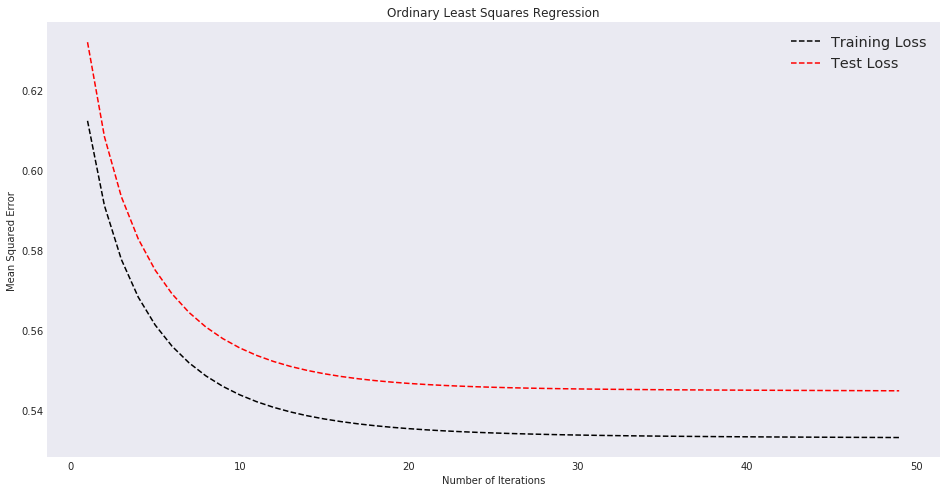

In [28]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

In [29]:
# save the models & their performance for comparison later (RUN THIS CELL AS IS)
np.savetxt(PWD + '/data/OLSmodels.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/OLSloss.csv', np.array([MSEtrain, MSEtest]), delimiter=',')

# Question 6: Cross Validation

In question 5 we mentioned that computing the loss after each iteration is not strictly a part of Gradient Descent, its just convenient for visualizing our progress. This "third step" however comes with a tradeoff: it requires an extra pass through the data. Normally this would cause us to cringe except for the fact that both the loss computation and the gradient computation are very easy to parallelize - lots of the work can be done in place no shuffle needed for the aggregation. 

[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), sometimes called rotation estimation, or out-of-sample testing, is a model validation technique for assessing how well the model will generalize to an independent data set. The goal of cross-validation is to test the model's ability to predict new data. 

Cross validation, which will solve the problem of the unreliable test-loss that we saw in question 5, presents a bit more of a scalability challenge. To avoid over-dependence on a particulary good or bad test/train split we divide the data into `k` roughly equal size parts and train `k` models. The `k-th` model is trained on all the data _except_ the `k-th` split which is used as a test set for that model. Finally we compute the loss by averaging together the test/train loss for each model. In this question we've provided a code base to perform gradient descent and cross validation in parallel. You'll fill in some of the key details based on your understanding from questions 1-5.

#### From ISLR Chapter 5.1 - Cross Validation
<img src="CV-ISLRp181.png">


### Q6 Tasks:
* __a) short response:__ A naive approach to training an OLS Regression model with cross validation might be to simply perform Gradient Descent on each of the 5 models in sequence. In this naive approach, how many total passes would be made over the data? [__`HINT:`__ _it will depend on factors that you should be able to name._]


* __b) short response:__ Read through the provided helper function `kResiduals()` and note where it gets used in the subsequent function `CVLoss()`. For each record in the original dataset, how many tuples does `kResiduals()` emit? What are the keys of these newly emitted records? How will these keys help us compute cross validated loss?


* __c) code:__ Complete the missing Spark code in `CVLoss()` so that this function returns the test/train cross validated error for a given set of data splits and their corresponding models. [__`TIP:`__ _your goal is to start from `partialLossRDD` and compute the test & train loss for each model so that the provided code can take the final average_].


* __d) code:__ Read through the provided functions `partialGradients()` and `CVUpdate()`. These should have a familiar feel. Fill in the missing line in `CVUpdate()` to update each model and add the (new) array of coefficients to the `new_models` list. 


* __e) short response:__ Read `GradientDescent_withCV()` and then run the provided code to perform 50 iterations and plot the error curves. What can you conclude from this graph? 

### Q6 Student Answers:
> __a)__ The total passes will depend on the `nSteps` factor specified in the `GradientDescent()` function - each step, we need to pass through the data 2 times. If we are running 5-fold CV, we need to pass through $nSteps \times 2 \times 5$ times. Note that the number of times passing through data before setting up `trainRDD` and `testRDD` are not included. 

> __b)__ For each record in the original dataset, `kResiduals()` emits two tuples. The keys are `{modelNum}-test` or `{modelNum}-train`. The keys help us to link residuals to each model number and identify whether it's on train or test data. We could then calculate the average loss of all models on train and test data. 

> __e)__ Comparing this graph with the graph of Q5, we can see that with cross validation, our error decreases, especially for test data. The loss remains stable after around iteration 30, as opposed to iteration 20 in Q5. 

In [30]:
# part b - helper function to emit residuals (RUN THIS CELL AS IS)
def kResiduals(dataPoint, models, splitNum):
    """
    Compute the (squared) residuals for a data point given k different models.
    Note that points from the k-th split are part of the test set for model number k
    and part of the training set for all other models. We'll emit a key to track this.
    Args:
        dataPoint - tuple of (features_array, y)
        models    - list of arrays representing model weights (bias at index 0)
    Returns:
        (stringFormattedKey, squared_error)
    """
    # augment the data point with a bias term at index 0
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit squared residuals for each model
    for modelNum, W in enumerate(models):
        if modelNum == splitNum:
            yield(f"{modelNum}-test", (W.dot(X) - y)**2)
        else:
            yield(f"{modelNum}-train", (W.dot(X) - y)**2)

In [31]:
# part c - fill in the missing code below
def CVLoss(dataSplits, models):
    """
    Compute the k-fold cross-validated test and train loss.
    Args:
        dataSplits - list of RDDs corresponding to the k test splits.
        models     - list of k arrays representing model weights (bias at index 0)
    Returns: 
        tuple of floats: (training_loss, test_loss)
    """
    # compute k residuals for each dataPoint (one for each model)
    partialLossRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        residuals = splitRDD.flatMap(lambda x: kResiduals(x, models, splitNum))
        partialLossRDD = sc.union([partialLossRDD, residuals])
    
    ################ YOUR CODE HERE #################        
    loss = partialLossRDD.map(lambda x: (x[0], [x[1],1]))\
                         .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                         .mapValues(lambda x: x[0]/x[1])\
                         .collect()
    
    
    ################ (END) YOUR CODE ################# 
    
    test_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'test'])
    training_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'train'])
    return training_loss, test_loss

In [32]:
# part d - helper function RUN THIS CELL AS IS
def partialGradients(splitNum, dataPoint, models):
    """
    Emit partial gradient for this data point for each model.
    NOTE: a data point from split-number k is in the test set for 
    model-k so we don't compute a partial gradient for that model.
    """
    # augment the data point
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit partial gradients for each model with a counter for averaging later
    for modelNum, W in enumerate(models):
        if modelNum != splitNum:
            yield (modelNum, [(W.dot(X) - y)*X, 1])

In [33]:
# part d - perform GD updates for all k models (FILL IN MISSING CODE BELOW)
def CVUpdate(dataSplits, models, learningRate = 0.1):
    """
    Compute gradients for k models given k corresponding dataSplits.
    NOTE: the training set for model-k is all records EXCEPT those in the k-th split.
    """
    # compute partial gradient k-1 times for each fold
    partialsRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        thisFoldPartialGrads = splitRDD.flatMap(lambda x: partialGradients(splitNum, x, models))
        partialsRDD = sc.union([partialsRDD, thisFoldPartialGrads])

    # compute gradients by taking the average partialGrad for each fold
    gradients = partialsRDD.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                           .mapValues(lambda x: x[0]/x[1])\
                           .map(lambda x: x[1])\
                           .collect()
    
    # update all k models & return them in a list
    new_models = []
    for W, grad in zip(models, gradients):
        ############# YOUR CODE HERE ############
        new_models.append(W - learningRate*grad)
        ############# (END) YOUR CODE ###########
    return new_models

In [34]:
# part e - RUN THIS CELL AS IS
def GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 5, verbose = False):
    """
    Train k models in parallel and track cross validated test/train loss.
    Returns:
        train_hist - (list) of floats
        test_hist - (list) of floats
        model_hist - (list) of arrays representing model coefficients (bias at index 0)
    """
    # broadcast initial models (one for each fold)
    bModels = sc.broadcast([wInit] * len(dataSplits))
    
    # initialize lists to track performance
    train_loss_0, test_loss_0 = CVLoss(dataSplits, bModels.value)
    train_hist, test_hist, model_hist = [train_loss_0], [test_loss_0], [wInit]
    
    # perform k gradient updates at a time (one for each fold)
    start = time.time()
    for step in range(nSteps):
        new_models = CVUpdate(dataSplits, bModels.value, learningRate)
        bModels = sc.broadcast(new_models)

        # log progress
        train_loss, test_loss = CVLoss(dataSplits, bModels.value)
        train_hist.append(train_loss)
        test_hist.append(test_loss)
        model_hist.append(new_models[0])
        
        if verbose:
            print("-------------------")
            print(f"STEP {step}: ")
            print(f"model 1: {[round(w,4) for w in new_models[0]]}")
            print(f" train loss: {round(train_loss,4)}")
            print(f" test loss: {round(test_loss,4)}")
            
    print(f"\n... trained {nSteps} iterations in {time.time() - start} seconds")
    return train_hist, test_hist, model_hist

In [35]:
# part d -  run 50 iterations (RUN THIS CELL AS IS)
dataSplits = normedRDD.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed = 2018) 
wInit = BASELINE
trainLoss, testLoss, models = GradientDescent_withCV(dataSplits, wInit, nSteps = 50, verbose=False)


... trained 50 iterations in 188.11564898490906 seconds


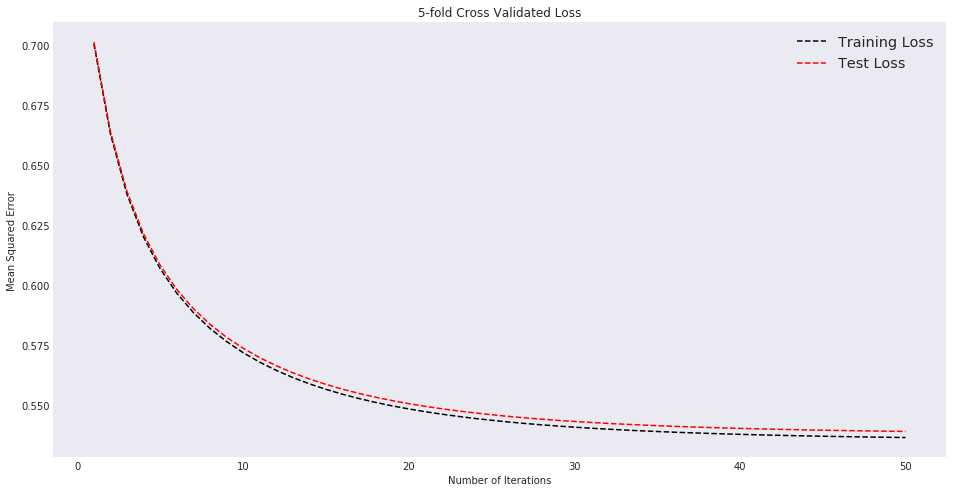

In [36]:
# part d - take a look (RUN THIS CELL AS IS)
plotErrorCurves(trainLoss, testLoss, title = '5-fold Cross Validated Loss' )

# Question 7: Regularization.

Our goal, as always, is to build a linear model that will extend well to unseen data. Chosing the right combination of features to optimize generalizability can be extremely computationally costly given that there are $2^{p}$ potential models that can be built from $p$ features. Traditional methods like forward selection would involve iteratively testing these options to asses which combinations of features achieve a statistically significant prediction.

Ridge Regression and Lasso Regression are two popular alternatives to OLS, which enable us to train generalizable models without the trouble of forward selection and/or manual feature selection.  Both methods take advantage of the bias-variance tradeoff by _shrinking_ the model coefficients towards 0 which reduces the variance of our model with little increase in bias. In practice this 'shrinkage' is achieved by adding a penalty (a.k.a. 'regularization') term to the means squared error loss function. In this question you will implement Gradient Descent with ridge and lasso regularization.

__`IMPORTANT NOTE:`__ When performing regularization _do not_ include the bias in your regularization term calcultion (Recall, that throughout this assignment we've included the bias at index 0 in the vector of weights that is your model).

### Q7 Tasks:
* __a) short response:__ The regularization term for ridge regression is the square of the $L2$ norm of the weights vector (i.e. the sum of squares of the coefficients) times the regularization parameter, $\lambda$. Write the formulas for both the loss function and the gradient for Ridge Regularization and explain what extra step this will add to our gradient descent algorithm.


* __b) short response:__ The regularization term for lasso regression is the $L1$ norm of the weights vector (i.e. the sum of the absolute values of the coefficients) times the regularization parameter, $\lambda$. Write the formulas for both the loss function and the gradient for Lasso Regularization and explain how the gradient descent update in Lasso will be different than it was in Ridge.


* __c) code:__ Fill in the first two missing code blocks in `GDUpdate_wReg()` so that this function will perform a single parameter update using $L2$ regularization if the parameter `regType` is set to `ridge`, $L1$ regularization if set to `lasso` and unregularized OLS otherwise.


* __d) code + short response:__ Use the provided code to train 50 iterations of ridge and lasso regression and plot the test/train error. Comment on the curves you see. Does this match your expectation?

### Q7 Student Answers:
> __a)__ The loss function with Ridge Regularization is 
\begin{equation}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta} \cdot \mathbf{x}^{'T}_{i} - y_i\right]^2 + \lambda \cdot \boldsymbol{\theta}^2
\end{equation}  

> The gradient formula is
\begin{equation}
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \boldsymbol{\theta} \cdot\mathbf{x}^{'T}_i - y_i\right] \cdot \mathbf{x}'_i + 2 \lambda \cdot \boldsymbol{\theta}
\end{equation} 

> Extra steps to be added to our gradient descent algorithm are:
- Add the $\lambda \cdot \boldsymbol{\theta}^2$ term to our loss function after reducing;
- Add the $2 \lambda \cdot \boldsymbol{\theta}$ term to our GD update function when calculating gradient

> __b)__ The loss function with Lasso Regularization is 
\begin{equation}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta} \cdot \mathbf{x}^{'T}_{i} - y_i\right]^2 + \lambda \cdot |\boldsymbol{\theta}|
\end{equation}  

> The gradient formula is
\begin{equation}
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \boldsymbol{\theta} \cdot\mathbf{x}^{'T}_i - y_i\right] \cdot \mathbf{x}^{'T}_i \pm \lambda
\end{equation}   

> The biggest difference is that when calculating the gradient for Lasso, we need to consider both the magnitude and orientation (sign) of our $\boldsymbol{\theta}$ vector. 

> __d)__ Obersvations on the plots:
- For Ridge, the train loss and test loss are similar, with test loss slightly less than train before around iteration 18, and train loss slightly less than test afterwards. This is within expectation in that with the increase in iteration, our model would get closer to the globa minima. 
- For Lasso, the train loss and test loss are similar, with test loss slightly less than train before around iteration 18, and train loss slightly less than test afterwards. In addition, the curve for test loss is moderately fluctuating. 
- Overall, it seems that Ridge performed marginally better than Lasso, which does not meet my expectation, as I thought Lasso would have a better performance. 

In [37]:
# part c - gradient descent with regularization
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    #################### YOUR CODE HERE ###################    
    grad_noReg = augmentedData.map(lambda x: np.dot((np.dot(W, np.transpose(x[0])) - x[1]), np.transpose(x[0]))*2)\
                              .mean()
    
    grad, update = None, None
    if regType == 'ridge':
        grad = grad_noReg + regParam * 2 * W
        update = learningRate * grad
        update[0] = 0 # first value of weight vector is bias term, ignored in regularization
        new_model = W - update

    elif regType == 'lasso':
        grad = grad_noReg + regParam * np.sign(W)
        update = learningRate * grad
        update[0] = 0 # first value of weight vector is bias term, ignored in regularization
        new_model = W - update

    else:
        update = learningRate * grad_noReg
        new_model = W - update
    
    ################## (END) YOUR CODE ####################
    return new_model

In [38]:
# part d - ridge/lasso gradient descent function
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        train_history.append(OLSLoss(trainRDD, model))
        test_history.append(OLSLoss(testRDD, model))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [39]:
# run 50 iterations of ridge (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
ridge_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50, 
                                     regType='ridge', regParam = 0.05 )
print(f"\n... trained {len(ridge_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 27.818796396255493 seconds


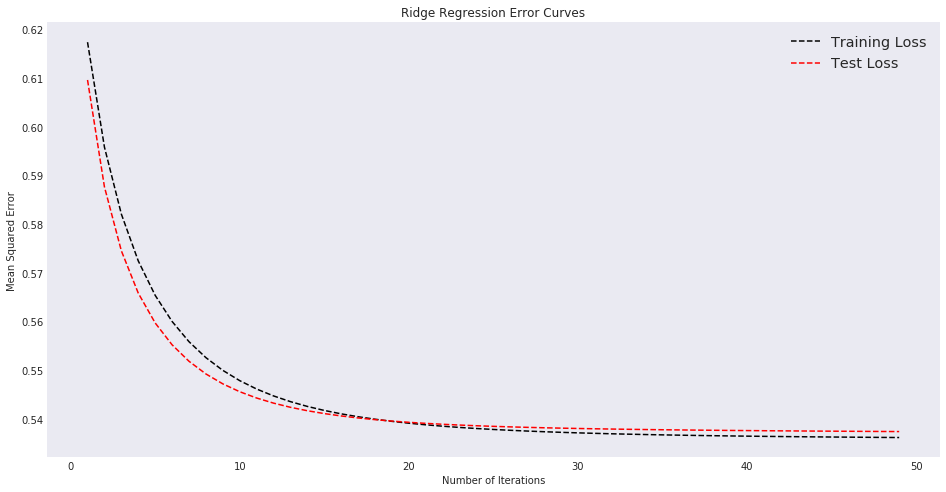

In [40]:
# part d - save and display ridge results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = ridge_results
np.savetxt(PWD + '/data/ridge_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/ridge_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Error Curves' )

In [41]:
# run 50 iterations of lasso (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
lasso_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50,
                                     regType='lasso', regParam = 0.05)
print(f"\n... trained {len(lasso_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 26.737565517425537 seconds


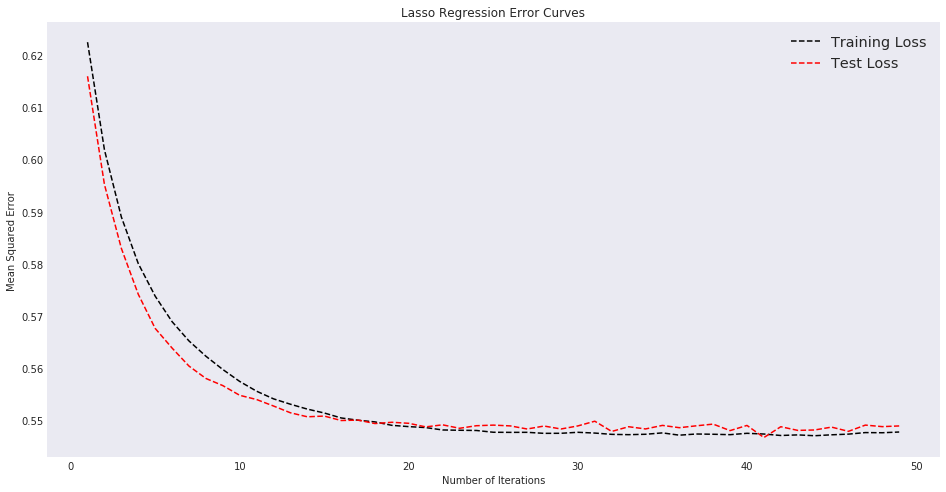

In [42]:
# part d - save and display lasso results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = lasso_results
np.savetxt(PWD + '/data/lasso_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/lasso_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

# Question 8: Results

In this final question we'll use a few different plots to help us compare the OLS, Ridge and Lasso models that we have trained. Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method.

### Q8 Tasks:
* __a) code:__ Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method. Then compute the mean squared error on the held out dataset for each of the three models. [__`TIP:`__ _the held out data is in it's raw form, don't forget to parse and normalize before applying your calculations, you should also be careful to normalize using the same scaling parameters that you used for the training data._]

* __b) short response:__ Which model performed best? Discuss how you interpret these results and what you would want to try next.


* __c) short response:__ Use the provided code to plot side by side boxplots of the residuals vs. the outcome (i.e. `quality`). What can you observe about our model performance? [__`TIP:`__ _note that the heldout data set is plenty small enough to fit in memory so no need to sample. Feel free to do your plotting in pandas or any other comfortable python package._]


* __d) short response:__ Run the provided code to visualize the model coefficients for the first 50 iterations of training. What do you observe about how the OLS, ridge and lasso coefficients change over the course of the training process. Please be sure to discuss all three in your response.

### Q8 Student Answers:
> __b)__ Based on the MSE results, OLS model without any regularization performs best among the three, with Ridge model as the next most performant, and Lasso the least. This is because for both Ridge and Lasso, we have added positive terms to the loss function. That's why their MSE results are higher than OLS model. I would run GridSearchCV to find a better $\lambda$ for Ridge and Lasso respectively. 

> __c)__ From the side-by-side boxplots, we see that:
- For all three models, when true quality score is on the lower range (less than 6), the predicted scores have less-than-zero error, meaning the predicted score is higher than actual score; whereas, when true quality score is on the higher range (more than 6), the predicted scores have more-than-zero error, meaning the predicted score is lower than actual score. Therefore, we can conclude that all three models tend to score the quality towards neutral range (around 6). 
- The performances of OLS and Ridge models are very close when true quality scores are in the neutral range (from 4 to 8). However, we can see slight differences in model performance at score = 3 and 9: Ridge seems to have larger spread in error at score 3, whereas OLS seems to have larger spread in error at score 9. 
- For Lasso, it presents a marginally smaller spread in error for score 3 to 8, with a few more outliers at score 5 and 7, but larger spread at score 9. 

> __d)__ Oberseration on coefficients curves:
- **OLS**:
    - Coefficient curves for all factors reach to certain stable values after iteration 20;
    - `Alcohol` having the largest positive coefficient, and `volatile acidity` having the largest negative coefficient. 
    - No factor has zero coefficient. 
    - Except `alcohol`, `volatile acidity`, `density`, and `chlorides`, all other factors start off from close values and gradually spread out in iterations. 
    - Correlated factors end up with similar coefficients in the end, for example `fixed acidity` and `pH`, as well as `free sulfur dioxide` and `sulphates`. 
- **Ridge**: overall, the coefficient curves of Ridge are very similar to the curves of OLS. 
    - Coefficient curves for all factors reach to certain stable values after iteration 20;
    - `Alcohol` having the largest positive coefficient, and `volatile acidity` having the largest negative coefficient. 
    - No factor has zero coefficient. 
    - Except `alcohol`, `volatile acidity`, `density`, and `chlorides`, all other factors start off from close values and gradually spread out in iterations. 
    - The coefficient for `citric acid` ends up closer to zero in Ridge model than in OLS model. 
- **Lasso**: overall, the coefficient curves of Lasso are relatively more different than OLS and Ridge. 
    - The key difference is that the coefficients of several factors reach zero (or at least very close to zero) in Lasso model, as opposed to factors all nonzero in OLS or Ridge. Therefore, we have a clearer picture in knowing the major contributors to quality than the other two models. 
    - Another difference is that even after many iteration, the coefficient curves still fluctuate, as opposed to staying stable in OLS or Ridge models. 
    - `Alcohol` has a bigger weight (close to 4) in Lasso model than in other models (close to 3.5).
    - In Lasso, correlated factors do not share similar coefficients as in OLS or Ridge, but rather only one of the correlated factors have non-zero coefficients, the others' are near zero.  

In [43]:
# part a - load the models from file (RUN THIS CELL AS IS)
ols_models = np.loadtxt(PWD + '/data/OLSmodels.csv', dtype=float, delimiter=',')
ridge_models = np.loadtxt(PWD + '/data/ridge_models.csv', dtype=float, delimiter=',')
lasso_models = np.loadtxt(PWD + '/data/lasso_models.csv', dtype=float, delimiter=',')
best_ols = ols_models[-1,:]
best_ridge = ridge_models[-1,:]
best_lasso = lasso_models[-1,:]

In [44]:
# part a - compute MSE on the held out data for all three 'best' models
olsMSE, ridgeMSE, lassoMSE = None, None, None
############### YOUR CODE HERE #################
# 1. Cache heldOutRDD
heldOutRDDCached = heldOutRDD.map(parse).cache()

# 2. Normalize heldOutRDDCached
validationRDD = normalize(heldOutRDDCached).cache()

# 3. Calculate MSE for all three 'best' models
olsMSE = OLSLoss(validationRDD, best_ols)
ridgeMSE = OLSLoss(validationRDD, best_ridge)
lassoMSE = OLSLoss(validationRDD, best_lasso)


############### YOUR CODE HERE #################

print(f"OLS Mean Squared Error: {olsMSE}")
print(f"Ridge Mean Squared Error: {ridgeMSE}")
print(f"Lasso Mean Squared Error: {lassoMSE}")

OLS Mean Squared Error: 0.5528930634616994
Ridge Mean Squared Error: 0.5540657905680478
Lasso Mean Squared Error: 0.5613629253370047


In [45]:
# part c - helper function (RUN THIS CELL AS IS)
def get_residuals(dataRDD, model):
    """
    Return a collected list of tuples (residual, quality_score)
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    residuals = augmentedData.map(lambda x: (x[1] - model.dot(x[0]), x[1]))
    return residuals.collect()

In [46]:
# part c - compute residuals for all three models (RUN THIS CELL AS IS)
ols_resid = np.array(get_residuals(validationRDD, best_ols))
ridge_resid = np.array(get_residuals(validationRDD, best_ridge))
lasso_resid = np.array(get_residuals(validationRDD, best_lasso))

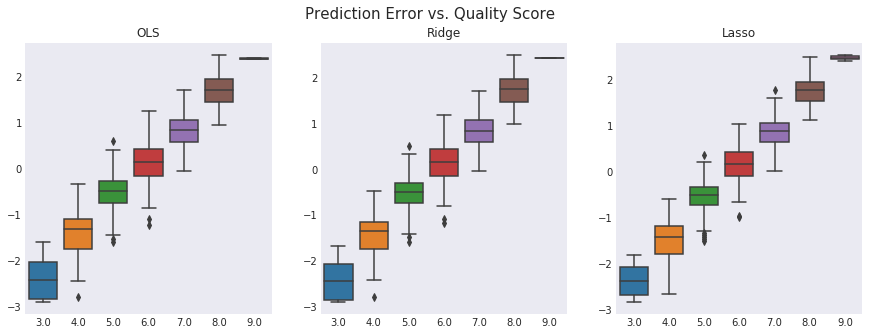

In [47]:
# part c - boxplots of residuals for all three models (RUN THIS CELL AS IS)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
stuff_to_plot = zip(axes, ["OLS", "Ridge", "Lasso"], [ols_resid, ridge_resid, lasso_resid])
for ax, title, data in stuff_to_plot:
    ax.set_title(title)
    y = data[:, 0]
    x = data[:, 1]
    sns.boxplot(x, y, ax=ax)
fig.suptitle("Prediction Error vs. Quality Score", fontsize=15, y=0.98)
plt.show()

In [48]:
# part d - plotting function (RUN THIS CELL AS IS)
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    plt.show

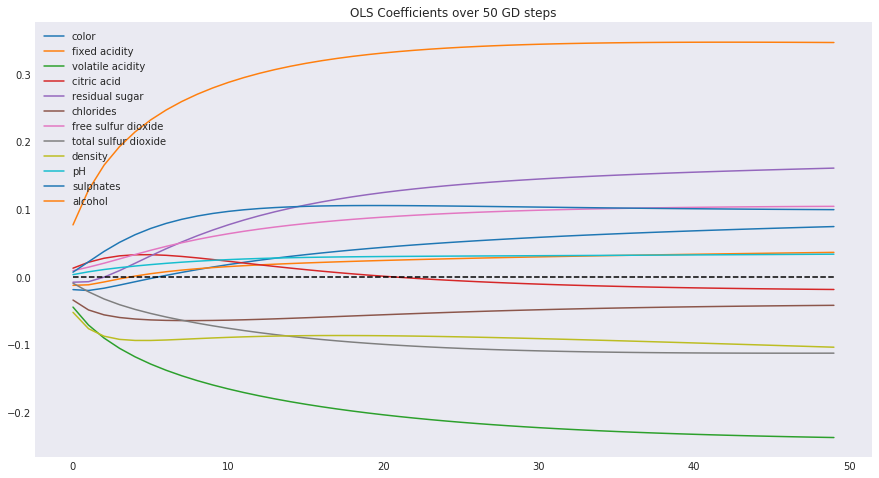

In [49]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ols_models, ['Bias'] + FIELDS, "OLS Coefficients over 50 GD steps")

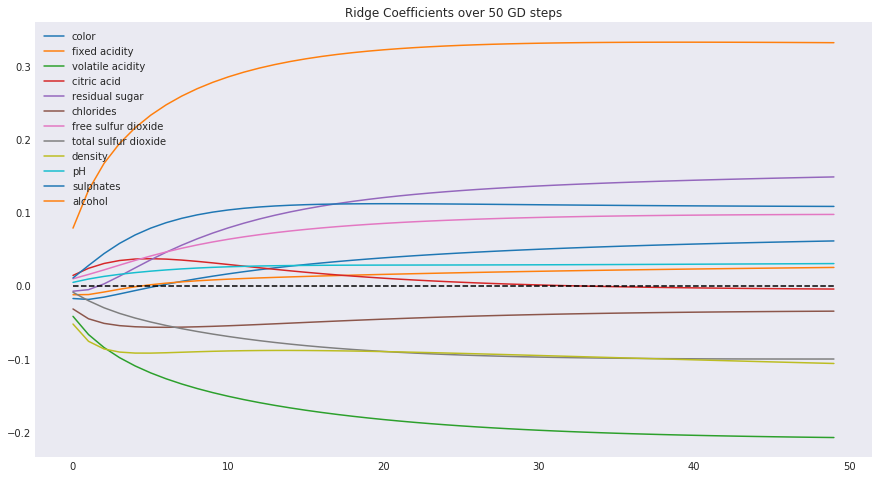

In [50]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ridge_models, ['Bias'] + FIELDS, "Ridge Coefficients over 50 GD steps")

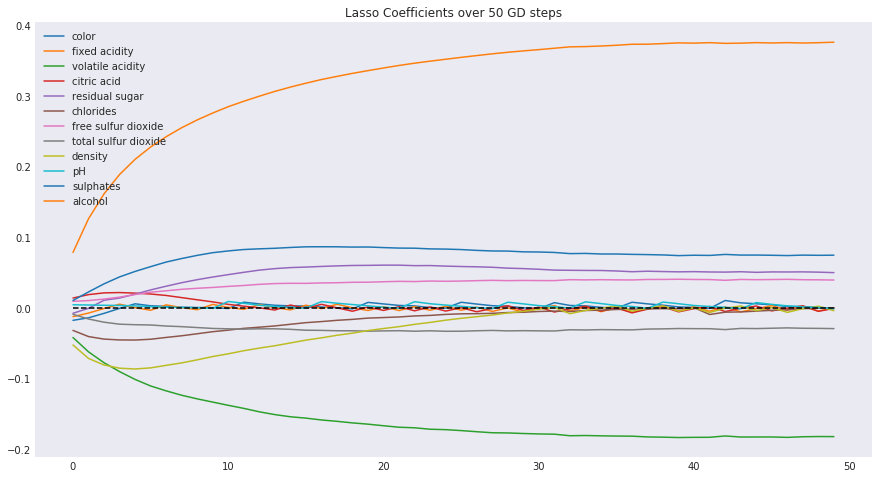

In [51]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(lasso_models, ['Bias'] + FIELDS, "Lasso Coefficients over 50 GD steps")

### Congratulations, you have completed HW4! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLScgIz4laP2JHChStLZx8MO0jGvrGyrOyQBnj7M4_4vcVXkB7g/viewform?usp=sf_link

*If you liked this assignment, checkout some additional EDA here: 
https://medium.com/swlh/effective-visualization-of-multi-dimensional-data-a-hands-on-approach-b48f36a56ee8*